# RE-MANGLE spectra
We need to re-mangle spectra because what we did in the 2dim fitting is "in principle" wrong.

In the 2dim grid we compared synthetic photometry @ average filter wavelength with Flux spectral density.
You should use eff wavelength, which is avg filter wavelength weighted for the underlying SED.

Now that we have extrapolated an approximated estimate of the underlying SEDs we need to iterativly warp&re-measure eff wvl of the SED until observed photometry and synthesized photometry is matching.

Read Section 2.2.2 of the paper if you are confused!!

    

In [44]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/4_LCs_late_extrapolated/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_DIR = COCO_PATH+"Outputs/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf


In [45]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import scipy.optimize as opt
import sncosmo

import matplotlib.cm as cm
import scipy
from itertools import cycle

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

import astropy.units as u
%matplotlib inline

In [46]:
### I NEED TO ASSUME SOME COSMOLOGY IF I WANT TO GET ABSOLUTE FLUX TEMPLATES (AS IF THEY WERE AT 10pc)
import astropy.cosmology
mycosmo = astropy.cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [47]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o','Bessell_B': 'o', 'Bessell_V':'o', 'Bessell_R':'o', 'Bessell_I': 'o', 
             'sdss_g':'s','ptf_g':'s', "sdss_g'":'s', 'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s', 'sdss_z':'s', "sdss_z'":'s', 'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o', 'Ks':  'o','K':  'o',
                'swift_UVW1':'D', 'swift_UVW2':'D', 'swift_UVM2':'D', 'swift_U':'D',
                'swift_V':'D', 'swift_B':'D'}

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

convert2mjd = (lambda x: float(x.replace('_spec_extended.txt','')\
                               .replace('_spec_extended_FL.txt','')\
                               .replace('_spec_extended_SMOOTH.txt','')))

#exclude_filt = ['H','Ks', 'J', 'K']

In [48]:
info_objects = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')

In [49]:
def calc_lam_eff(wls, transmission, flux):
    return (integrate.trapezoid(transmission*flux*wls, wls)/\
            integrate.trapezoid(transmission*flux, wls))

def prop_err_div(x,y,sig_x,sig_y):
    return ((sig_x/y)**2  +  ((x*sig_y)/y**2)**2 )**0.5

In [50]:
class ReMangle_SingleSpectrumClass():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, snname, twodim=True, spec_file=None, verbose=False):
        """
        """
        ## Initialise the class variables            
        self.snname = snname
        self.check_results_folder()
        self.extension_type='2dim' if twodim else 'classic'
        self.create_FINALspec_folder()
        
        if spec_file is None:
            print ("Choose one spec_file from this list:")
            print (self.get_spec_list())
        else:
            self.spec_file = spec_file
            print ('self.spec_file', self.spec_file)
            self.load_manglingfile()
        self.load_final_info()

    def check_results_folder(self):
        results_directory = OUTPUT_DIR+'/%s/'%self.snname
        if not os.path.exists(results_directory):
            print ("I cant mangle a spectrum if I theres no fitted LC yet")
        else: self.results_mainpath = results_directory

    def check_extended_file(self):
        if self.extension_type == '2dim':
            mangled_file_path = OUTPUT_DIR+'/%s/TwoDextended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        else:
            mangled_file_path = OUTPUT_DIR+'/%s/extended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        if not os.path.isfile(mangled_file_path):
            print ("Sorry, This object %s has not mangled file"%mangled_file_path)
        else: 
            self.mangled_file_path = mangled_file_path

    def get_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = OUTPUT_DIR+'/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = OUTPUT_DIR+'/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended.txt' in f]
        return onlyfiles

    def check_spec_manglingphot(self):
        all_specs = self.get_spec_list()
        mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
        phot4mangling = pd.read_csv(mangling_file, sep='\t')
        for spec_file in all_specs:
            file_mjd = float(spec_file.replace('_spec_extended.txt',''))
            mask = phot4mangling['spec_mjd'].values == file_mjd
            if len(phot4mangling[mask])==0:
                print ('There.s no magnling photometry fro this. Are you sure nothing went wrong?', spec_file)
                print ('I compared', phot4mangling['spec_mjd'].values ,file_mjd)

    def get_FLAGGED_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = OUTPUT_DIR+'/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = OUTPUT_DIR+'/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_FL.txt' in f]
        return onlyfiles

    def get_SMOOTH_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = OUTPUT_DIR+'/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = OUTPUT_DIR+'/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SMOOTH.txt' in f]
        return onlyfiles


    def get_SNF_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = OUTPUT_DIR+'/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = OUTPUT_DIR+'/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SNF.txt' in f]
        return onlyfiles

    
    def load_original_phot(self, verbose = False):
        SNphotometry_PATH = os.path.join(OUTPUT_DIR+'/%s/fitted_phot_%s.dat'%(self.snname,self.snname))
        #lc_file = np.genfromtxt(SNphotometry_PATH, names=True, dtype=None,encoding="utf-8")
        lc_pd = pd.read_csv(SNphotometry_PATH, sep='\t')
        self.original_phot = lc_pd
        return lc_pd
    
    def load_manglingfile(self):
        if not hasattr(self, "results_mainpath"):
            self.check_results_folder()
        else:
            if (not 'FL.txt' in self.spec_file)&(not 'SNF.txt' in self.spec_file)&(not 'SMOOTH.txt' in self.spec_file):
                mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
                phot4mangling = pd.read_csv(mangling_file, sep='\t')
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling['spec_mjd'].values == file_mjd
                self.phot4mangling = (phot4mangling[mask])
                if len(self.phot4mangling)<1:
                    raise Exception(""" ### ERROR: 
                    I looked in the file with the PHOTOMETRY for MANGLING 
                    (i.e. fitted_phot4mangling_SNNAME.dat).
                    I was loading the photometry to mangle/extend the spectrum you are currently loading
                    in the GRID. I found NO photometry for it... Maybe you should re run GP fit or check your list of spec.""")

                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                #Rav aded this to skip H, J, K for now because causing errors
                self.avail_filters = [f for f in self.avail_filters if f not in exclude_filt]
                
            elif 'SNF.txt' in self.spec_file: 
                phot4mangling = self.load_original_phot()
                file_mjd = float(self.spec_file.replace('_spec_extended_SNF.txt',''))
                
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                
                #Rav aded this to skip H, J, K for now because causing errors
                self.avail_filters = [f for f in self.avail_filters if f not in exclude_filt]
            else: 
                phot4mangling = self.load_original_phot()
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                #Rav aded this to skip H, J, K for now because causing errors
                self.avail_filters = [f for f in self.avail_filters if f not in exclude_filt]

    def load_extended_spec(self):
        if not hasattr(self, 'extended_files_path'):
            lista = self.get_spec_list()
        ext_spec = np.genfromtxt(self.extended_files_path+self.spec_file,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'fluxerr'])
        self.ext_spec = ext_spec
        return ext_spec
  
    def create_mangledspec_folder(self):
        mangledspec_directory = OUTPUT_DIR+'/%s/RE_mangled_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(mangledspec_directory):
            os.makedirs(mangledspec_directory)
        self.mangledspec_path = mangledspec_directory
   
    def create_FINALspec_folder(self):
        FINAL_directory = OUTPUT_DIR+'/%s/FINAL_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(FINAL_directory):
            os.makedirs(FINAL_directory)
        if not os.path.exists(FINAL_directory+'/HostNotCorr/'):
            os.makedirs(FINAL_directory+'/HostNotCorr/')
        if not os.path.exists(FINAL_directory+'/as_observed/'):
            os.makedirs(FINAL_directory+'/as_observed/')
            
        self.FINALspec_path = FINAL_directory

    def calculate_ratios4mangling(self, use_what_4phot=None):
        ratios=[]
        ratios_err=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        used_filters=[]
        
        outMJD_ratios=[]
        outMJD_ratios_err=[]
        outMJD_fitted_phot_list=[]
        outMJD_fitted_photerr_list=[]
        outMJD_wls_eff=[]
        outMJD_used_filters=[]
        for filt in self.avail_filters:
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values[0]
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values[0]
            
            if '%s_inrange'%filt in self.phot4mangling.columns: 
                inMJDrange_pnt = self.phot4mangling['%s_inrange'%filt].values[0]
            else: # this means the spectrum is synthesized from the 2dim surface
                inMJDrange_pnt = ~np.isnan(fitted_phot)

            lam_eff, raw_phot, raw_phot_err = self.band_flux(filt, use_what = use_what_4phot)

            # reject bad data before appending to anything
            if (
                np.isnan(fitted_phot) or
                np.isnan(raw_phot) or
                np.isnan(fitted_phot_err) or
                raw_phot == 0 or
                np.isinf(fitted_phot_err / fitted_phot)
            ):
                print(f"Skipping {filt} due to bad values: fitted_phot={fitted_phot}, raw_phot={raw_phot}, fitted_phot_err={fitted_phot_err}")
                continue

            if (not inMJDrange_pnt):
                outMJD_fitted_phot_list.append(fitted_phot)
                outMJD_fitted_photerr_list.append(fitted_phot_err)
                outMJD_ratios.append(fitted_phot/raw_phot)
                                #outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                outMJD_wls_eff.append(lam_eff)
                outMJD_used_filters.append(filt)
            else:
                fitted_phot_list.append(fitted_phot)
                fitted_photerr_list.append(fitted_phot_err)
                ratios.append(fitted_phot/raw_phot)
                #ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err , 0.) )
                wls_eff.append(lam_eff)
                used_filters.append(filt)
        #print ('ratios',len(ratios))
        ratios = np.array(ratios)
        wls_eff = np.array(wls_eff)
        ratios_err = np.array(ratios_err)
        used_filters = np.array(used_filters)
        outMJD_wls_eff = np.array(outMJD_wls_eff)
        outMJD_used_filters = np.array(outMJD_used_filters)

        
        self.fitted_phot_dict = {'eff_wls':wls_eff, 'fitted_phot':fitted_phot_list,\
                                     'fitted_phot_err':fitted_photerr_list, 'used_filters': used_filters}

        return ratios, ratios_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters

    def GP_interpolation_mangle(self, wls_eff, ratios, ratios_err, min_scale, optimization=True):
        if len(self.ext_spec['wls'])>10**4:
            # GP struggle to handle such a big number of points
            int_fraction = int(len(self.ext_spec['wls'])/5000.)
            print ('This spectrum has a huge amount of data points(%i), Im chopping a %i th of them'%(len(self.ext_spec['wls']), int_fraction))
            full_wls = self.ext_spec['wls'][::int_fraction]
        else:
            full_wls = self.ext_spec['wls']
        
        norm_wls = np.median(full_wls)
        full_wls_normed = full_wls/norm_wls
        wls_eff_normed = np.array(wls_eff)/norm_wls
            
        offset=1.
        #changed this
        #norm = np.mean(ratios)
        norm = np.nanmean(ratios)
        ratios_normed = np.array(ratios)/norm-offset
        ratios_err_normed = np.array(ratios_err)/norm

        print(f'ratios: {ratios}')
        print(f'ratios normed: {ratios_normed}')
        print(f'ratios err: {ratios_err}')
        print(f'ratios err normed: {ratios_err_normed}')
        print(f'mean: {norm}')
        
        if len(ratios_normed)<1:
            return np.ones(len(full_wls_normed))*np.nan, np.ones(len(full_wls_normed))*np.nan
        else:
            def ll(p):
                #print (np.exp(p))
                if (np.exp(p)[1]<5*10**-3):#|(np.exp(p)[1]>10**5):
                    return np.inf
                else:
                    gp.set_parameter_vector(p)
                    return -gp.lnlikelihood(ratios_normed, quiet=False)#
            def grad_ll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_lnlikelihood(ratios_normed, quiet=False)
            #changed this k to skip nans - fix later
            #k= np.var(ratios_normed)*Matern32Kernel(0.3)
            k = np.nanvar(ratios_normed)*Matern32Kernel(0.3)
            print(k)
            wls_eff_normedT = np.atleast_2d(wls_eff_normed).T
            gp = george.GP(k)
            #print("ratios_err_normed:", ratios_err_normed)
            #print("Any NaNs?", np.any(np.isnan(ratios_err_normed)))
            #print("Any infs?", np.any(np.isinf(ratios_err_normed)))
            #print("wls_eff:", wls_eff)
            wls_eff_normedT = np.ravel(wls_eff_normedT)  # or .flatten()
            print("wls_eff_normedT:", wls_eff_normedT)
            #print("Any NaNs in wls_eff_normedT?", np.any(np.isnan(wls_eff_normedT)))
            #print("Any infs in wls_eff_normedT?", np.any(np.isinf(wls_eff_normedT)))
            #print("wls_eff_normedT shape:", wls_eff_normedT.shape)
            #print("ratios_err_normed shape:", ratios_err_normed.shape)
            gp.compute(wls_eff_normedT, (ratios_err_normed))
            #gp.compute(wls_eff_normedT, ratios_err_normed)
            if optimization:
                try:
                    p0=gp.get_parameter_vector()
                    results = opt.minimize(ll, p0, jac=grad_ll)
                    print ('SCALE:',  '%.4f'%np.exp(results.x[1]))
                except:
                    pass
                    print ('*** GP optimization failed ***'*10)
            #print ('results', np.exp(results.x))
            mu, cov = gp.predict(ratios_normed, full_wls_normed)
            std = np.sqrt(np.diag(cov))
                
            if len(self.ext_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                mu_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], mu)
                std_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], std)
            else:
                mu_full = mu
                std_full = std
            return norm*(mu_full+offset), np.abs(norm*(std_full))


    def band_flux(self, filter_name, use_what='ext_spectrum'):
        if use_what == 'ext_spectrum':
            spec_flux = self.ext_spec
            #print ('Im using the UNmangled one')
        else:
            spec_flux = self.mangled_spec[use_what]
            #print ('Im using the %s-TIME mangled one'%use_what)

        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])

        #cut_spec = [(spec_flux['wls']>min(filt_transm['wls']))&\
                     #(spec_flux['wls']<max(filt_transm['wls']))]
        cut_spec = (spec_flux['wls']>min(filt_transm['wls']))&\
                     (spec_flux['wls']<max(filt_transm['wls']))
        #cut_ext_spec = spec_flux[cut_spec].copy()
        cut_ext_spec = spec_flux[cut_spec]

        #added these prints
        #print(filter_name)
        #print(len(cut_ext_spec))

        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], 
                                                       filt_transm['flux'], 
                                                       kind='linear')
        filt_transm_interp = filt_transm_interp_func(cut_ext_spec['wls'])
        filt_transm_interp_xLambda = filt_transm_interp*cut_ext_spec['wls']
        
        lam_eff = calc_lam_eff(cut_ext_spec['wls'], 
                                        filt_transm_interp, 
                                        cut_ext_spec['flux']) 

        raw_phot = integrate.trapezoid(filt_transm_interp_xLambda*cut_ext_spec['flux'], cut_ext_spec['wls'])/\
                 integrate.trapezoid(filt_transm_interp_xLambda, cut_ext_spec['wls'])
            
        raw_phot_err = (integrate.trapezoid((filt_transm_interp_xLambda*cut_ext_spec['fluxerr'])**2, 
                                        cut_ext_spec['wls']))**0.5/\
                 integrate.trapezoid(filt_transm_interp_xLambda, cut_ext_spec['wls'])
        if use_what == 'ext_spectrum': 
            return lam_eff, raw_phot, raw_phot_err
        else: 
            return lam_eff, raw_phot, raw_phot_err

    def mangle_iteration_function(self):
        print(f"[DEBUG] Starting mangling for: {self.spec_file}")
        if ('FL' in self.spec_file):
            min_scale=0.5
            optimization=False
        else:
            min_scale=0.5#min_scale=5*10**-3
            optimization=False#optimization=True
        
        print("[DEBUG] Calling calculate_ratios4mangling (initial)")
        # 1st iteration        
        ratios_0, ratios_0_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
            self.calculate_ratios4mangling(use_what_4phot='ext_spectrum')
        
        print("[DEBUG] Calling GP_interpolation_mangle (initial)")
        mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_0, 
                                                                ratios_0_err, min_scale, 
                                                                optimization=optimization)

        print("[DEBUG] Applying initial mangling mask")
        mangled_spec = self.ext_spec['flux'] * mang_mask
        mangled_spec_err = ((self.ext_spec['flux'] * mang_mask_err)**2)**0.5

        self.mangled_spec = {0 : np.array([a for a in zip(self.ext_spec['wls'],
                                                            mangled_spec, mangled_spec_err)],
                                     dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])}
        self.mangling_mask = {0 : (mang_mask, mang_mask_err) }
        
        mangled_phot_list=[]
        for filt in used_filters:
            mangled_phot_list.append(self.band_flux(filt, use_what=0)[1])
        self.magled_photometry_dict = {0 : {'eff_wls': wls_eff, 
                                              'fitted_phot': mangled_phot_list,\
                                           'used_filters': used_filters}}

        # More iterations
        ratios = ratios_0
        max_iteration = 5
        for i in range(max_iteration):
            print(f"[DEBUG] Iteration {i} - max(ratios-1): {np.max(np.abs(ratios-1.))}")
            if max(np.abs(ratios-1.))>0.01:
                print("[DEBUG] Calling calculate_ratios4mangling...")
                #print (i)
                ratios_iter, ratios_iter_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
                    self.calculate_ratios4mangling(use_what_4phot=(i))
                print("[DEBUG] Calling GP_interpolation_mangle...")
                mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_iter, 
                                                                            ratios_iter_err, min_scale, 
                                                                        optimization=optimization)
                #print ('iteration', i,ratios_iter)
                print("[DEBUG] Applying mangling mask to spectrum...")
                mangled_spec = self.mangled_spec[i]['flux'] * mang_mask
                #mangled_spec_err = ( (self.mangled_spec[str(i+1)]['flux'] * mang_mask_err)**2 +\
                #            (self.mangled_spec[str(i+1)]['fluxerr'] * mang_mask)**2 )**0.5
                print("[DEBUG] Saving mangled spectrum and errors...")
                mangled_spec_err = (self.mangled_spec[i]['flux'] * mang_mask_err)

                #print ('save new', (i+1))
                self.mangled_spec[i+1] = np.array([a for a in zip(self.ext_spec['wls'], 
                                                                       mangled_spec, mangled_spec_err)],
                                         dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])
                
                self.mangling_mask[i+1] = (mang_mask, mang_mask_err)
                print("[DEBUG] Calculating band fluxes...")
                #RAV - TRYING TO REPLACE THIS, SEE IF IT WORKS
                #mangled_phot_list=[]
                #for filt in used_filters:
                    #mangled_phot_list.append(self.band_flux(filt, use_what=i+1)[1])

                print(f"[DEBUG] used_filters = {used_filters}")
                mangled_phot_list = []

                for filt in used_filters:
                    print(f"[DEBUG] Computing band_flux for filter: {filt}")
                    try:
                        phot_val = self.band_flux(filt, use_what=4)[1]
                        if not np.isfinite(phot_val):
                            print(f"[WARNING] band_flux returned non-finite value for {filt}: {phot_val}")
                        mangled_phot_list.append(phot_val)
                    except Exception as e:
                        print(f"[ERROR] band_flux failed for filter {filt}: {e}")
                        break
                #down to here is what i added
                self.magled_photometry_dict[i+1] = {'eff_wls': wls_eff, 'fitted_phot': mangled_phot_list,\
                                                       'used_filters': used_filters}
                ratios = np.copy(ratios_iter)
                print(f"[DEBUG] Finished iteration {i}")
            else:
                pass
        self.mangling_mask_FINAL = mangled_spec/self.ext_spec['flux']
        iters_list = list(self.mangled_spec.keys())
        last_iter = iters_list[-1]
        #print ('last_iter', last_iter)
        self.final_mangled_spec = self.mangled_spec[last_iter]
        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]

        print('skipping plotting for now')
        '''

        print(f"[DEBUG] Plotting results for file: {self.spec_file}")
        matplotlib.use('Agg')
        fig=plt.figure(1, figsize=(10,6))
        print("[DEBUG] Created figure")
        ax1 = plt.subplot2grid((3,1), (0,0))
        print("[DEBUG] Plotting ax1 data")
        for f,w,r,rerr in zip(used_filters, wls_eff,\
                              ratios_0, ratios_0_err):
            ax1.errorbar(w, r, yerr=rerr, marker='o', mfc= color_dict[f], mec=color_dict[f], linestyle='None',\
                     ecolor= color_dict[f], label='%s'%f)
        #print (iters_list)
        for it in (iters_list):
            mask, mask_err = self.mangling_mask[it]
            ax1.errorbar(self.ext_spec['wls'], mask, color='orange', lw=0.3, alpha=0.5)
            ax1.fill_between(self.ext_spec['wls'], mask-mask_err, mask+mask_err, 
                             color='orange',alpha=0.3)
        ax1.errorbar(self.ext_spec['wls'], self.mangling_mask_FINAL, 
                     color='red', linestyle=':', lw=1.5, alpha=0.9)
        ax1.fill_between(self.ext_spec['wls'], self.mangling_mask_FINAL-mask_err, self.mangling_mask_FINAL+mask_err,
                     facecolor='red', alpha=0.5)

        ax1.set_ylabel('Phot from LCfitting /\n Phot from Raw Spec')
        ax1.set_xlabel('Effective Wavelenght')
        ax1.set_title('%s: Mangled spectrum %s'%(self.snname, self.spec_file))
        ax1.set_xlim(1600., 10500.)
        ax1.legend(ncol=5, fontsize=6)

        #print('eff_wls length:', len(self.fitted_phot_dict['eff_wls']))
        #print('fitted_phot length:', len(self.fitted_phot_dict['fitted_phot']))
        #print('fitted_phot_err length:', len(self.fitted_phot_dict['fitted_phot_err']))
        print("[DEBUG] Plotting ax2 data")
        ax2 = plt.subplot2grid((3,1), (1,0), rowspan=2)
        print("[DEBUG] Checking NaN/inf in mangled_spec...")
        print("wls:", np.any(~np.isfinite(self.mangled_spec[last_iter]['wls'])))
        print("flux:", np.any(~np.isfinite(self.mangled_spec[last_iter]['flux'])))
        print("fluxerr:", np.any(~np.isfinite(self.mangled_spec[last_iter]['fluxerr'])))

        print("[DEBUG] Checking NaN/inf in ext_spec...")
        print("wls:", np.any(~np.isfinite(self.ext_spec['wls'])))
        print("flux:", np.any(~np.isfinite(self.ext_spec['flux'])))

        print("[DEBUG] Checking NaN/inf in fitted phot...")
        print("eff_wls:", np.any(~np.isfinite(self.fitted_phot_dict['eff_wls'])))
        print("fitted_phot:", np.any(~np.isfinite(self.fitted_phot_dict['fitted_phot'])))
        print("fitted_phot_err:", np.any(~np.isfinite(self.fitted_phot_dict['fitted_phot_err'])))

        print("[DEBUG] Checking NaN/inf in magled photometry...")
        print("eff_wls:", np.any(~np.isfinite(self.magled_photometry_dict[last_iter]['eff_wls'])))
        print("fitted_phot:", np.any(~np.isfinite(self.magled_photometry_dict[last_iter]['fitted_phot'])))
        if ('FL' in self.spec_file)|('SNF' in self.spec_file):
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', linestyle='--', label='Mangled_Spec FAKE SPEC')
        else:
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', label='Mangled_Spec')

        ax2.errorbar(self.ext_spec['wls'], self.ext_spec['flux'],\
                     lw=0.7, color='r', label='Raw Spec')
        ax2.errorbar(self.fitted_phot_dict['eff_wls'], self.fitted_phot_dict['fitted_phot'],\
                     yerr=self.fitted_phot_dict['fitted_phot_err'], marker='o',
                     linestyle='None', label='Fitted Phot')
        ax2.errorbar(self.magled_photometry_dict[last_iter]['eff_wls'],
                     self.magled_photometry_dict[last_iter]['fitted_phot'],\
                     marker='^', mfc='r', mec='r', linestyle='None', label='Phot from mangled spec')
        ax2.plot(self.magled_photometry_dict[iters_list[-1]]['eff_wls'], 
                 self.magled_photometry_dict[iters_list[-1]]['fitted_phot'],\
                 marker='.', mfc='r', mec = 'None', linestyle='None')
        print ('ITERATION', last_iter, iters_list[-1])
        ax2.fill_between(self.mangled_spec[last_iter]['wls'], 
                         self.mangled_spec[last_iter]['flux']-self.mangled_spec[last_iter]['fluxerr'],\
                         self.mangled_spec[last_iter]['flux']+self.mangled_spec[last_iter]['fluxerr'], 
                         color='grey',alpha=0.3)
        ax2.set_ylabel('Flux erg s-1 cm-2 A-1')
        ax2.set_xlabel('Wavelenght')
        ax2.set_xlim(1600., 10500.)
        ax2.legend()
        print("[DEBUG] Saving figure to ...")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        if 'FL' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.png'),
                        bbox_inches='tight')
        elif 'SNF' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.pdf'),
                        bbox_inches='tight')
        else:
            fig.savefig(self.mangledspec_path+'%.6f_REmangled_spec.png'%spec_number, bbox_inches='tight')
            
        print("[DEBUG] Plot saved, closing figure")
        plt.close(fig)

        '''
        
        print(f"[DEBUG] Saving final mangled spectrum")
        self.save_mangled_spectrum()
        return list(self.mangled_spec.keys())

        
    def get_diff_FittedMangled_phot(self):
        fitted_phot = np.array(self.fitted_phot_dict['fitted_phot'])
        fitted_phot_err = np.array(self.fitted_phot_dict['fitted_phot_err'])
        mangled_phot = np.array(self.magled_photometry_dict['fitted_phot'])
        diff_mag = -2.5*np.log10(mangled_phot/fitted_phot)
        
        def err_fromFlux_toMag(flux, err_flux):
            flux = np.array(flux, dtype=float)
            err_flux = np.array(err_flux, dtype=float)
            return 2.5/np.log(10.) * err_flux/flux
    
        fitted_phot_err_mag = err_fromFlux_toMag(fitted_phot, fitted_phot_err)
        discrepancy_mag = diff_mag/fitted_phot_err_mag
        return self.magled_photometry_dict['used_filters'], diff_mag, discrepancy_mag 

    def get_filter_transmission(self, f):
        filt_transm = np.genfromtxt(self.main_path+'filters/%s.dat'%f,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        return filt_transm

    def save_mangled_spectrum(self):

        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you have to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        
        save_path = self.mangledspec_path

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        if 'FL' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.txt'), 'w')
        elif 'SMOOTH' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SMOOTH.txt','_REmangled_spec_SMOOTH.txt'), 'w')
        elif 'SNF' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.txt'), 'w')
        else:
            fout = open(self.mangledspec_path+'/%.6f_REmangled_spec.txt'%spec_number, 'w')

        fout.write('#wls\tflux\tfluxerr\n')
        for w,f,ferr in zip(self.ext_spec['wls'], self.final_mangled_spec['flux'], self.final_mangled_spec['fluxerr']):
            fout.write('%E\t%E\t%E\n'%(w,f,ferr))
        fout.close() 
        
        
    def load_final_info(self):
        mask = info_objects.Name==self.snname
        if len(info_objects[mask])==0:
            raise Exception((' !!!!!!!!!!!!! \n I CANT FIND THIS OBJECT IN THE FINAL_info.dat FILE!! \n Add it to the PYCOCO/info/FINAL_info.dat first.'))
        return (info_objects[mask])
        
        
    def save_FINAL_spectrum(self):
        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you need to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'FINALspec_path')):
            self.create_FINALspec_folder()

        flux = self.final_mangled_spec['flux']
        fluxerr = self.final_mangled_spec['fluxerr']
        
        sn_info = self.load_final_info()        
        MWdust = sncosmo.CCM89Dust()
        Hostdust = sncosmo.CCM89Dust()
        r_v = 3.1
        z = sn_info['z'].values[0]
        
        wls = self.ext_spec['wls']
        wls_restframe = self.ext_spec['wls']/(1+z)
        
        # MW corrections in SN restframe
        MW_ebv = sn_info['EBV_MW'].values[0]
        MWdust.parameters = [MW_ebv, r_v]
        MW_extinction_perc = MWdust.propagate(wls_restframe, np.ones(len(flux)))
        
        # Host corrections in SN restframe
        Host_ebv = sn_info['EBV_host'].values[0]
        Hostdust.parameters = [Host_ebv, r_v]
        Host_extinction_perc = Hostdust.propagate(wls, np.ones(len(flux)))

        dist = 10**(mycosmo.distmod(z).value/5.+1)
        To_abs_lum = (dist/10.)**2

        self.final_spec_wls = wls_restframe
        self.HostCorr_spec_flux = To_abs_lum*flux
        self.HostCorr_spec_fluxerr = To_abs_lum*fluxerr

        self.HostNOTCorr_spec_flux = To_abs_lum*flux*Host_extinction_perc
        self.HostNOTCorr_spec_fluxerr = To_abs_lum*fluxerr*Host_extinction_perc
        
        self.as_observed_spec_flux = flux*Host_extinction_perc*MW_extinction_perc
        self.as_observed_spec_fluxerr = fluxerr*Host_extinction_perc*MW_extinction_perc

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        
        
        for path_fold in ['', '/HostNotCorr/','/as_observed/']:
            path = self.FINALspec_path + path_fold
            if 'FL' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_FL.txt','_FINAL_spec_FL.txt'), 'w')
            elif 'SMOOTH' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SMOOTH.txt','_FINAL_spec_SMOOTH.txt'), 'w')
            elif 'SNF' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SNF.txt','_FINAL_spec_SNF.txt'), 'w')
            else:
                fout = open(path+'/%.6f_FINAL_spec.txt'%spec_number, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            if path_fold=='':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostCorr_spec_flux, 
                                self.HostCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 
            elif path_fold=='/HostNotCorr/':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostNOTCorr_spec_flux, 
                                self.HostNOTCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 
            
            elif path_fold=='/as_observed/':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.as_observed_spec_flux, 
                                self.as_observed_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 

        #if self.snname in Alternative_RV_dict.keys():
        #    different_r_v = 3.1
        #    Host_ebv  = 0.0        
#
#            Hostdust.parameters = [Host_ebv, different_r_v]
#            Host_extinction_perc = Hostdust.propagate(wls, np.ones(len(flux)))
#
#            self.HostNOTCorr_spec_flux = To_abs_lum*flux*Host_extinction_perc
#            self.HostNOTCorr_spec_fluxerr = To_abs_lum*fluxerr*Host_extinction_perc
#

In [51]:
# do for KN
snname='AT2017gfo'

#prepare output folder
# delete if the folder already exist
mangledspec_directory = OUTPUT_DIR+'/%s/RE_mangled_spectra_%s/'%(snname, '2dim')
os.system('rm -rf %s'%mangledspec_directory)
os.makedirs(mangledspec_directory)

FINAL_directory = OUTPUT_DIR+'/%s/FINAL_spectra_%s/'%(snname, '2dim')
os.system('rm -rf %s'%FINAL_directory)
os.makedirs(FINAL_directory)


### FIRST: Remangle the "true" spectra (i.e. real spectra that we only had to extend in UV)

In [52]:
# do for KN
new_spec= ReMangle_SingleSpectrumClass(snname=snname, twodim=True,\
                            spec_file=None, verbose=True)

Choose one spec_file from this list:
['57987.980002_spec_extended.txt', '57988.990003_spec_extended.txt', '57984.969003_spec_extended.txt', '57991.000003_spec_extended.txt', '57987.980003_spec_extended.txt', '57988.990002_spec_extended.txt', '57984.969002_spec_extended.txt', '57990.000003_spec_extended.txt', '57985.974003_spec_extended.txt', '57990.000002_spec_extended.txt', '57985.974002_spec_extended.txt', '57983.969002_spec_extended.txt', '57983.969003_spec_extended.txt', '57986.974002_spec_extended.txt', '57986.974003_spec_extended.txt']


In [53]:
new_spec= ReMangle_SingleSpectrumClass(snname=snname, twodim=True,\
                    spec_file=None, verbose=True)
for a in new_spec.get_spec_list()[:]:
    print (a)
    new_spec= ReMangle_SingleSpectrumClass(snname=new_spec.snname, twodim=True,\
                        spec_file=a, verbose=False)
    new_spec.load_extended_spec()
    result = new_spec.mangle_iteration_function()
    new_spec.save_FINAL_spectrum()

Choose one spec_file from this list:
['57987.980002_spec_extended.txt', '57988.990003_spec_extended.txt', '57984.969003_spec_extended.txt', '57991.000003_spec_extended.txt', '57987.980003_spec_extended.txt', '57988.990002_spec_extended.txt', '57984.969002_spec_extended.txt', '57990.000003_spec_extended.txt', '57985.974003_spec_extended.txt', '57990.000002_spec_extended.txt', '57985.974002_spec_extended.txt', '57983.969002_spec_extended.txt', '57983.969003_spec_extended.txt', '57986.974002_spec_extended.txt', '57986.974003_spec_extended.txt']
57987.980002_spec_extended.txt
self.spec_file 57987.980002_spec_extended.txt
[DEBUG] Starting mangling for: 57987.980002_spec_extended.txt
[DEBUG] Calling calculate_ratios4mangling (initial)
[DEBUG] Calling GP_interpolation_mangle (initial)
This spectrum has a huge amount of data points(12370), Im chopping a 2 th of them
ratios: [1.35104184 0.79628052 0.27429793 0.8945199  1.48213518 1.0649599 ]
ratios normed: [ 0.38255599 -0.18514559 -0.71930384 -

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 0.7257020659763387
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(12370), Im chopping a 2 th of them
ratios: [1.36817451 0.77953763 0.27515749 0.94714291 1.44541217 1.03168941]
ratios normed: [ 0.40394849 -0.20007961 -0.7176479  -0.02809192  0.48320571  0.05866524]
ratios err: [5.36618703 0.3878836  1.21575407 0.0925883  0.30937391 0.095156  ]
ratios err normed: [5.50649798 0.39802568 1.24754267 0.09500923 0.31746318 0.09764407]
mean: 0.9745190221109544
ConstantKernel(log_constant=-1.836816181624685, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.95568483 1.17920308 1.02797554 1.61298765 1.3255483  1.91362303]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 2.8074383699240335
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(22777), Im chopping a 4 th of them
ratios: [ 0.80896065  0.          0.88292469 -0.56553404  5.7042399   4.55310636
  1.20218663]
ratios normed: [-0.55007336 -1.         -0.50893614 -1.31453796  2.17257641  1.53234052
 -0.33136947]
ratios err: [5.45142241 0.         0.48557084 2.28322546 2.66463467 1.09708855
 0.12331717]
ratios err normed: [3.03196473 0.         0.27006413 1.26988124 1.4820129  0.61017722
 0.06858638]
mean: 1.7979834551407132
ConstantKernel(log_constant=0.40237158542309, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.57489387 1.10619364 0.69586043 0.62517984 0.92363756 0.80792216
 1.19773293]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Sav

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(23423), Im chopping a 4 th of them
ratios: [3.19460265 0.         0.49762337 1.97268193 1.03018464 1.04285414
 0.99958701]
ratios normed: [ 1.55932843 -1.         -0.60133332  0.58039716 -0.17467644 -0.16452637
 -0.19918946]
ratios err: [0.8359934  0.         0.18162457 0.20173773 0.13377119 0.189022
 0.09906012]
ratios err normed: [0.66974892 0.         0.14550696 0.16162044 0.10716964 0.15143335
 0.07936116]
mean: 1.248219105854608
ConstantKernel(log_constant=-0.5043643990320092, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.58137182 0.74344685 0.69572664 0.61193632 0.98077805 0.83290377
 1.15632908]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band f

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'sdss_z']
[DEBUG] Computing band_flux for filter: Bessell_B
[ERROR] band_flux failed for filter Bessell_B: 4
[DEBUG] Finished iteration 0
[DEBUG] Iteration 1 - max(ratios-1): 0.6207134856077721
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(20049), Im chopping a 4 th of them
ratios: [0.45008018 1.01920121]
ratios normed: [-0.38734652  0.38734652]
ratios err: [22.30895424  0.06890658]
ratios err normed: [30.36716387  0.09379631]
mean: 0.7346406907215762
ConstantKernel(log_constant=-1.8968711729203231, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.54837074 1.11393205]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum an

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 0.731948764725231
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(23459), Im chopping a 4 th of them
ratios: [1.16294539 1.01146317 0.24972094 0.92817704 1.59266221 1.03768865]
ratios normed: [ 0.16631655  0.01439522 -0.74955516 -0.06913235  0.59727904  0.04069671]
ratios err: [4.56125137 0.50328554 1.10337139 0.0907344  0.34089112 0.09570933]
ratios err normed: [4.57447358 0.50474447 1.10656985 0.09099742 0.3418793  0.09598677]
mean: 0.9971095666492786
ConstantKernel(log_constant=-1.8400267059586055, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.57555011 0.70958911 0.61979303 0.97832608 0.8147335  1.16024748]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'Bessell_I' 'Bessell_V' 'sdss_g' 'sdss_i' 'sdss_r' 'sdss_z']
[DEBUG] Computing band_flux for filter: Bessell_B
[ERROR] band_flux failed for filter Bessell_B: 4
[DEBUG] Finished iteration 0
[DEBUG] Iteration 1 - max(ratios-1): 2.667452439829639
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(11859), Im chopping a 2 th of them
ratios: [ 0.98985192  0.          0.67751766 -0.66744154  5.58602364  1.64916153
  1.15780488]
ratios normed: [-0.26232046 -1.         -0.49508517 -1.49740567  3.16294118  0.22902495
 -0.13715481]
ratios err: [6.67041067 0.         0.37260571 2.69465705 2.6094105  0.39737179
 0.11876462]
ratios err normed: [4.97107227 0.         0.27768154 2.00817245 1.94464312 0.29613827
 0.08850842]
mean: 1.3418454416008678
ConstantKe

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(13552), Im chopping a 2 th of them
ratios: [2.07207362 0.         0.53623706 1.4212355  1.04510913 1.00013759
 1.00470486]
ratios normed: [ 1.0488057  -1.         -0.4697845   0.40527603  0.03337329 -0.01109324
 -0.00657727]
ratios err: [0.54223905 0.         0.19571792 0.14534373 0.13570925 0.18127943
 0.09956731]
ratios err normed: [0.53615009 0.         0.19352015 0.14371162 0.13418533 0.17924379
 0.09844924]
mean: 1.0113568219477207
ConstantKernel(log_constant=-1.0351468179789387, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.96392929 1.03720222 1.16447937 1.01049654 1.64122906 1.37099753
 1.93216332]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectru

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(22783), Im chopping a 4 th of them
ratios: [ 4.6654093   0.         -6.50947669  1.51816962]
ratios normed: [-58.2622429   -1.          78.89593438 -19.63369148]
ratios err: [3.48969719 0.         1.09447057 0.09366785]
ratios err normed: [-42.83180219  -0.         -13.43329936  -1.14965925]
mean: -0.08147444217660588
ConstantKernel(log_constant=7.824599782643791, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.55060629 1.20565442 0.97365811 1.19755776]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'Bessell_I' 'sdss_i' 'sdss_z']
[DEBUG] Computing band_flux for filter:

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(23731), Im chopping a 4 th of them
ratios: [0.86594483 0.         0.41266242 1.30516585 0.96817523 0.91533461
 1.02952721]
ratios normed: [ 0.10275116 -1.         -0.4744885   0.66208414  0.23293809  0.16564737
  0.31106774]
ratios err: [0.11105243 0.         0.16751715 0.05814584 0.05993651 0.16979413
 0.10439085]
ratios err normed: [0.14142148 0.         0.21332737 0.07404674 0.0763271  0.21622703
 0.13293818]
mean: 0.7852585924571923
ConstantKernel(log_constant=-1.3293660359962418, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.59566117 0.7588575  0.69093165 0.62856412 0.97548143 0.82616151
 1.1524028 ]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating ban

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
ratios: [1.3443848  0.         6.55249552 1.32208165]
ratios normed: [-0.41668713 -1.          1.84305133 -0.4263642 ]
ratios err: [1.00561913 0.         1.10170218 0.08156963]
ratios err normed: [0.4363264  0.         0.47801572 0.03539211]
mean: 2.3047404915147824
ConstantKernel(log_constant=0.1723244189605326, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.90547173 1.74364364 1.48174523 1.89306912]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'Bessell_I' 'sdss_i' 'sdss_z']
[DEBUG] Computing band_flux for filter: Bessell_B
[ERROR] band_flux failed for filter Bessell_B: 4
[DEBUG] Finished iteration 0
[DEBUG] It

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(13157), Im chopping a 2 th of them
ratios: [0.8412351  0.         0.36654673 1.31223774 1.0139959  0.97681028
 1.00978339]
ratios normed: [ 0.06666593 -1.         -0.53522754  0.66388599  0.28572248  0.23857201
  0.28038112]
ratios err: [0.10788428 0.         0.14879682 0.05846091 0.06277314 0.18119783
 0.10238888]
ratios err normed: [0.13679468 0.         0.1886708  0.07412703 0.07959484 0.2297545
 0.12982665]
mean: 0.78865844688073
ConstantKernel(log_constant=-1.2786835288239762, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.99090413 1.03010044 1.16046367 1.04450356 1.63084658 1.35341501
 1.92004244]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum a

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(13441), Im chopping a 2 th of them
ratios: [1.25386598 0.         0.50436414 0.72175863 1.11448373 0.91552443
 1.04233482]
ratios normed: [ 0.58078844 -1.         -0.36413219 -0.0900561   0.40506484  0.15423057
  0.31410443]
ratios err: [0.04009166 0.         0.16394313 0.12653313 0.24797408 0.16337342
 0.12324405]
ratios err normed: [0.05054482 0.         0.20668828 0.15952431 0.31262876 0.20597003
 0.15537767]
mean: 0.7931902478363348
ConstantKernel(log_constant=-1.3780179847785454, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.94212495 1.09053059 1.16356498 0.97489534 1.63595717 1.35982258
 1.92533967]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectru

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 1.0
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(23589), Im chopping a 4 th of them
ratios: [1.58026208 0.         0.31202828 0.86234153 1.22067375 1.35270562
 1.04951935]
ratios normed: [ 0.73450121 -1.         -0.65751666 -0.0534909   0.33981579  0.48473444
  0.15195613]
ratios err: [0.05052815 0.         0.10142454 0.15117896 0.27160138 0.24138749
 0.12409351]
ratios err normed: [0.05545988 0.         0.11132393 0.16593456 0.29811063 0.26494776
 0.13620547]
mean: 0.9110758018287182
ConstantKernel(log_constant=-1.092254950503595, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.56608107 0.84276135 0.69154922 0.5903171  0.9828397  0.82934602
 1.1568578 ]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Applying initial mangling mask
[DEBUG] Iteration 0 - max(ratios-1): 0.49712732696237816
[DEBUG] Calling calculate_ratios4mangling...
[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(12835), Im chopping a 2 th of them
ratios: [0.64313063 0.49569055 1.06280794 1.0015107  1.06424672 1.01925296]
ratios normed: [-0.27008759 -0.43742272  0.2062195   0.13665103  0.20785242  0.15678737]
ratios err: [0.18389857 0.22284994 0.05089861 0.03537986 0.20776631 0.10385603]
ratios err normed: [0.20871319 0.25292053 0.05776669 0.04015389 0.23580156 0.11786999]
mean: 0.8811065841766407
ConstantKernel(log_constant=-2.725016240169492, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.96419461 1.17512754 1.03283777 1.62153372 1.33328106 1.9137178 ]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxe

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_36186/1423875722.py:216: RuntimeWarning: invalid value encountered in scalar divide
  np.isinf(fitted_phot_err / fitted_phot)


[DEBUG] Calling GP_interpolation_mangle...
This spectrum has a huge amount of data points(23500), Im chopping a 4 th of them
ratios: [0.6300449  0.73756918 1.03519238 0.99141237 1.30615056 1.02233905]
ratios normed: [-0.33942652 -0.2266922   0.08535221  0.03945086  0.36943956  0.07187608]
ratios err: [0.18015371 0.33159249 0.04957596 0.03502312 0.25499172 0.10417047]
ratios err normed: [0.18888299 0.34765968 0.05197814 0.03672015 0.26734724 0.10921801]
mean: 0.9537847393424069
ConstantKernel(log_constant=-2.9403201228939655, ndim=1, axes=array([0])) * Matern32Kernel(metric=Metric(0.3, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)
wls_eff_normedT: [0.58284241 0.70010634 0.62461841 0.98018883 0.82379547 1.15805002]
[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'Bessell_V' 'sdss_g' 'sdss_i' 'sdss_r' 'sdss_z']
[DEBUG] Computing band_flux for filter: Bessell_B


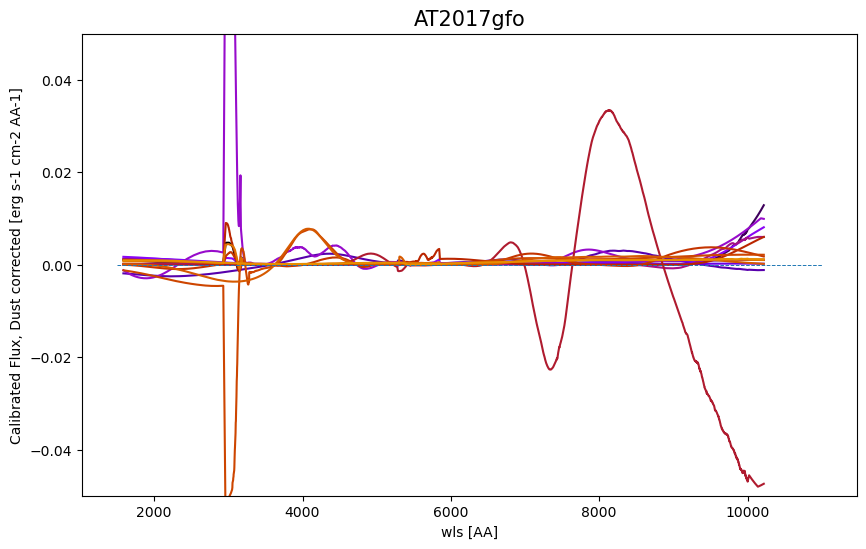

In [55]:
color=cycle(plt.cm.gnuplot(np.linspace(0,1,int(len(new_spec.get_spec_list())*1.2))))
fig= plt.figure(1, figsize=(10,6))
plt.title(new_spec.snname, fontsize=15)
mean=1.; a=0
for l in new_spec.get_spec_list()[:]:
    new_spec.create_FINALspec_folder()
    sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
    plt.plot(sp[:,0], sp[:,1], #+mean*a, 
             lw=1.5,color=next(color))
    if mean==1.:
        mean = np.median(sp[:,1])*0.2
    a=a+1
    
plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
plt.xlabel('wls [AA]')
plt.ylim(-0.05,.05)
fig.savefig(new_spec.FINALspec_path+'Final_Spec.png', bbox_inches='tight')
plt.show()
plt.close()

### SECOND: Remangle the "artificial" spectra (i.e. spectra that we extrapolated from the 2dim surface @phases were spectroscopy was too sparse)

In [56]:
#try for KN
new_spec= ReMangle_SingleSpectrumClass(snname=snname, twodim=True,\
                        spec_file=None, verbose=True)
for f in new_spec.get_FLAGGED_spec_list():
    new_spec= ReMangle_SingleSpectrumClass(snname=snname, twodim=True,\
                    spec_file=f, verbose=True)
    new_spec.load_extended_spec()
    result = new_spec.mangle_iteration_function()
    new_spec.save_FINAL_spectrum()

Choose one spec_file from this list:
['57987.980002_spec_extended.txt', '57988.990003_spec_extended.txt', '57984.969003_spec_extended.txt', '57991.000003_spec_extended.txt', '57987.980003_spec_extended.txt', '57988.990002_spec_extended.txt', '57984.969002_spec_extended.txt', '57990.000003_spec_extended.txt', '57985.974003_spec_extended.txt', '57990.000002_spec_extended.txt', '57985.974002_spec_extended.txt', '57983.969002_spec_extended.txt', '57983.969003_spec_extended.txt', '57986.974002_spec_extended.txt', '57986.974003_spec_extended.txt']
self.spec_file 57975.566667_spec_extended_FL.txt
[DEBUG] Starting mangling for: 57975.566667_spec_extended_FL.txt
[DEBUG] Calling calculate_ratios4mangling (initial)
Skipping Bessell_I due to bad values: fitted_phot=nan, raw_phot=9.251418732727631e-18, fitted_phot_err=nan
Skipping Bessell_U due to bad values: fitted_phot=nan, raw_phot=4.722529489915475e-17, fitted_phot_err=nan
[DEBUG] Calling GP_interpolation_mangle (initial)
ratios: [1.75827317 0.

/opt/anaconda3/envs/SED/lib/python3.12/site-packages/george/kernels.py:94: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


[DEBUG] Applying mangling mask to spectrum...
[DEBUG] Saving mangled spectrum and errors...
[DEBUG] Calculating band fluxes...
[DEBUG] used_filters = ['Bessell_B' 'Bessell_V' 'sdss_g' 'sdss_i' 'sdss_r' 'sdss_z']
[DEBUG] Computing band_flux for filter: Bessell_B
[DEBUG] Computing band_flux for filter: Bessell_V
[DEBUG] Computing band_flux for filter: sdss_g
[DEBUG] Computing band_flux for filter: sdss_i
[DEBUG] Computing band_flux for filter: sdss_r
[DEBUG] Computing band_flux for filter: sdss_z
[DEBUG] Finished iteration 3
[DEBUG] Iteration 4 - max(ratios-1): 0.917300315830182
[DEBUG] Calling calculate_ratios4mangling...
Skipping Bessell_I due to bad values: fitted_phot=nan, raw_phot=6.574280671942653e-17, fitted_phot_err=nan
Skipping Bessell_U due to bad values: fitted_phot=nan, raw_phot=1.4635759678933832e-16, fitted_phot_err=nan
[DEBUG] Calling GP_interpolation_mangle...
ratios: [1.74290181 0.78401489 1.64969845 1.00543884 1.10545244 0.9514091 ]
ratios normed: [ 0.44461015 -0.350166

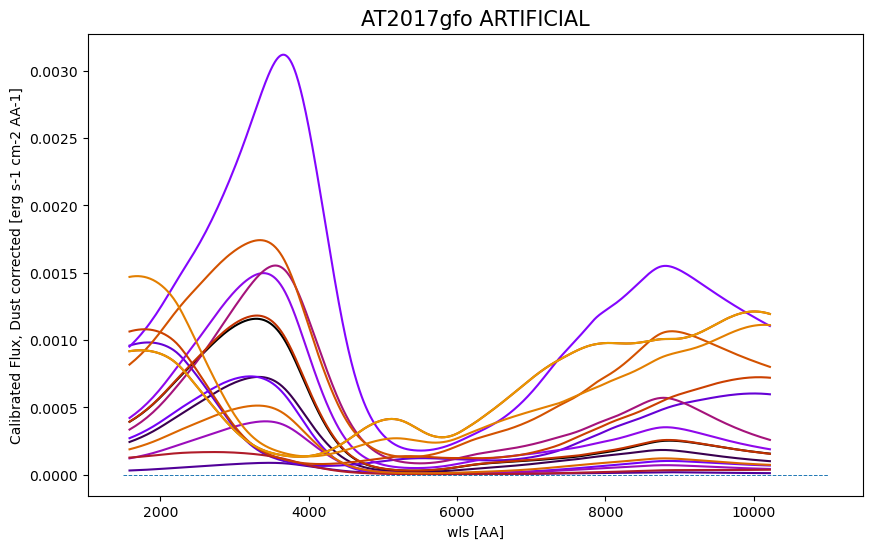

In [57]:
new_spec.create_FINALspec_folder()
color=cycle(plt.cm.gnuplot(np.linspace(0,1,int(len(new_spec.get_FLAGGED_spec_list())*1.2))))
fig= plt.figure(1, figsize=(10,6))
plt.title(snname+' ARTIFICIAL', fontsize=15)
mean=1.; a=0
for l in new_spec.get_FLAGGED_spec_list()[:]:
    sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
    plt.plot(sp[:,0], sp[:,1],#+mean*a,
             lw=1.5,color=next(color))
    if mean==1.:
        mean = np.median(sp[:,1])*0.2
    
plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
plt.xlabel('wls [AA]')
fig.savefig(new_spec.FINALspec_path+'Final_Spec_FL.png', bbox_inches='tight')
plt.show()
plt.close()

In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [59]:


def create_lookup_table(data_dir, wavelength_range=(2000, 10000), wavelength_bins=10000):
    """
    Load spectra data from files, interpolate onto a common wavelength grid,
    and create a lookup table (DataFrame) for flux values.

    Parameters:
    - data_dir: str, path to the directory containing spectra files.
    - wavelength_range: tuple, min and max wavelength range for interpolation.
    - wavelength_bins: int, number of bins for wavelength interpolation.

    Returns:
    - lookup_table: pd.DataFrame, fluxes indexed by time and columns as wavelengths.
    - days_from_start: np.ndarray, time in days from the first MJD.
    - common_wavelengths: np.ndarray, the interpolated wavelength grid.
    """
    # Collect all spectra files
    spectra_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".txt")])

    # Lists to store results
    mjds = []
    wavelengths = []
    fluxes = []

    # Loop through all spectra files
    for file in spectra_files:
        # Extract the MJD from the filename (assuming it starts with MJD)
        mjd = float(file.split("_")[0])
        mjds.append(mjd)

        # Load the data (assuming 3 columns: wavelength, flux, flux error)
        data = np.loadtxt(os.path.join(data_dir, file))
        wavelengths.append(data[:, 0])  # First column: wavelength
        fluxes.append(data[:, 1])       # Second column: flux

    # Convert lists to numpy arrays for easier handling
    mjds = np.array(mjds)
    wavelengths = np.array(wavelengths, dtype=object)  # Allow variable-length arrays
    fluxes = np.array(fluxes, dtype=object)

    # Define a common wavelength grid
    common_wavelengths = np.linspace(wavelength_range[0], wavelength_range[1], wavelength_bins)

    # Interpolate flux onto the common wavelength grid
    fluxes_interpolated = []
    for i in range(len(fluxes)):
        flux_interp = np.interp(common_wavelengths, wavelengths[i], fluxes[i], left=np.nan, right=np.nan)
        fluxes_interpolated.append(flux_interp)

    fluxes_interpolated = np.array(fluxes_interpolated)

    # Subtract the minimum MJD to get days from start
    days_from_start = mjds - mjds.min()

    # Create a pandas DataFrame for lookup
    lookup_table = pd.DataFrame(
        fluxes_interpolated,
        index=days_from_start,  # Time as index (days from start)
        columns=common_wavelengths  # Wavelength as columns
    )

    return lookup_table, days_from_start, common_wavelengths


def plot_spectrum(time_from_start, lookup_table, wavelengths):
    """
    Plot a spectrum (flux vs wavelength) for a given time.
    """
    # Find the closest time in the DataFrame
    closest_time = lookup_table.index[np.argmin(np.abs(lookup_table.index - time_from_start))]
    flux = lookup_table.loc[closest_time]

    # Plot the spectrum
    plt.figure(figsize=(8, 5))
    plt.plot(wavelengths, flux, label=f"Time = {closest_time:.2f} days")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
    plt.title("Spectrum at Time {:.2f} days".format(closest_time))
    plt.legend()
    plt.grid()
    plt.show()


def plot_lightcurve(wavelength, lookup_table):
    """
    Plot a light curve (flux vs time) for a given wavelength.
    """
    # Find the closest wavelength in the DataFrame
    closest_wavelength = lookup_table.columns[np.argmin(np.abs(lookup_table.columns - wavelength))]
    flux = lookup_table[closest_wavelength]

    # Plot the light curve
    plt.figure(figsize=(8, 5))
    plt.scatter(lookup_table.index, flux, label=f"Wavelength = {closest_wavelength:.2f} Å")
    plt.xlabel("Time (days from start)")
    plt.ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
    plt.title("Lightcurve at Wavelength {:.2f} Å".format(closest_wavelength))
    plt.legend()
    plt.grid()
    plt.show()


def plot_sed_evolution(lookup_table, common_wavelengths, days_from_start, vmin=3.321846586518659e-05, vmax=0.04521411733143501):
    """
    Create a 2D plot of spectral density evolution (time vs wavelength vs flux).

    Parameters:
    - lookup_table: pd.DataFrame, flux values with time as index and wavelengths as columns.
    - common_wavelengths: np.ndarray, the wavelength grid used for interpolation.
    - days_from_start: np.ndarray, the time in days from the first detection.
    - vmin: float, minimum flux value for color scaling.
    - vmax: float, maximum flux value for color scaling.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(
        lookup_table.values.T, 
        aspect='auto', 
        extent=[days_from_start.min(), days_from_start.max(), common_wavelengths.min(), common_wavelengths.max()],
        origin='lower', 
        cmap='viridis', 
        norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    plt.colorbar(label=r"Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
    plt.xlabel("Days from first detection")
    plt.ylabel("Wavelength (Å)")
    plt.title("SED Evolution")
    plt.show()



try my wavelength & time lookup code on kilonova:

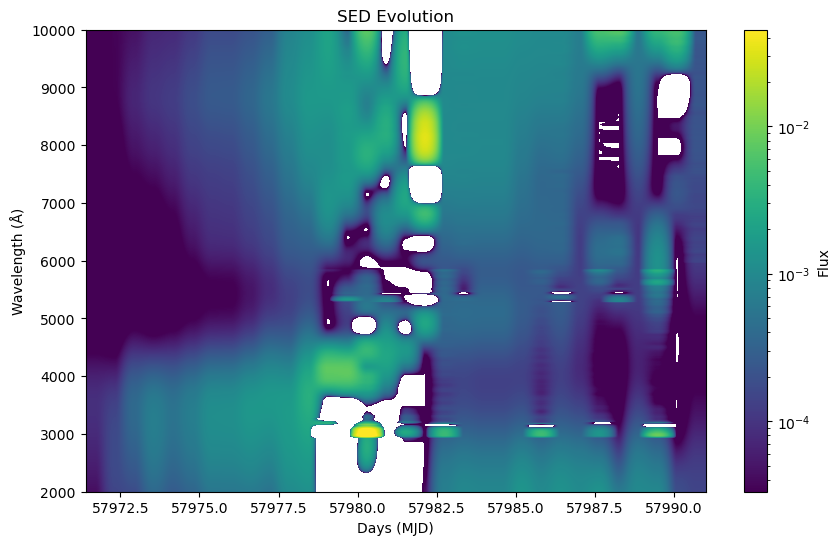

In [60]:
# Directory containing your spectra files
data_dir = "/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/Outputs/AT2017gfo/FINAL_spectra_2dim"

# Collect all files in the directory
spectra_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".txt")])

# Lists to store results
mjds = []
wavelengths = []
fluxes = []

# Loop through all spectra files
for file in spectra_files:
    # Extract the MJD from the filename (assuming it starts with MJD)
    mjd = float(file.split("_")[0])
    mjds.append(mjd)

    # Load the data (assuming 3 columns: wavelength, flux, flux error)
    data = np.loadtxt(os.path.join(data_dir, file))
    wavelengths.append(data[:, 0])  # First column: wavelength
    fluxes.append(data[:, 1])       # Second column: flux

# Convert lists to numpy arrays for easier handling
mjds = np.array(mjds)
wavelengths = np.array(wavelengths, dtype=object)  # Allow variable-length arrays
fluxes = np.array(fluxes, dtype=object)

# Define a common wavelength grid (e.g., union or interpolation grid)
common_wavelengths = np.linspace(2000, 10000, 500)  # Adjust wavelength range and resolution

# Interpolate flux onto the common wavelength grid
fluxes_interpolated = []
for i in range(len(fluxes)):
    flux_interp = np.interp(common_wavelengths, wavelengths[i], fluxes[i], left=np.nan, right=np.nan)
    fluxes_interpolated.append(flux_interp)

fluxes_interpolated = np.array(fluxes_interpolated)

# Create a 2D plot
plt.figure(figsize=(10, 6))
plt.imshow(
    fluxes_interpolated.T, 
    aspect='auto', 
    extent=[mjds.min(), mjds.max(), common_wavelengths.min(), common_wavelengths.max()],
    origin='lower', 
    cmap='viridis', 
    norm=LogNorm(vmin=3.321846586518659e-05, vmax=0.04521411733143501)  # Adjust vmin/vmax as needed
)
#plt.colorbar(label=r"Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.colorbar(label=r"Flux")
plt.xlabel("Days (MJD)")
plt.ylabel("Wavelength (Å)")
plt.title("SED Evolution")
plt.show()

In [17]:
# Example Usage:
# Path to directory with spectra files
data_dir = "/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/Outputs/AT2017gfo/FINAL_spectra_2dim"

# Create the lookup table
lookup_table, days_from_start, common_wavelengths = create_lookup_table(data_dir)

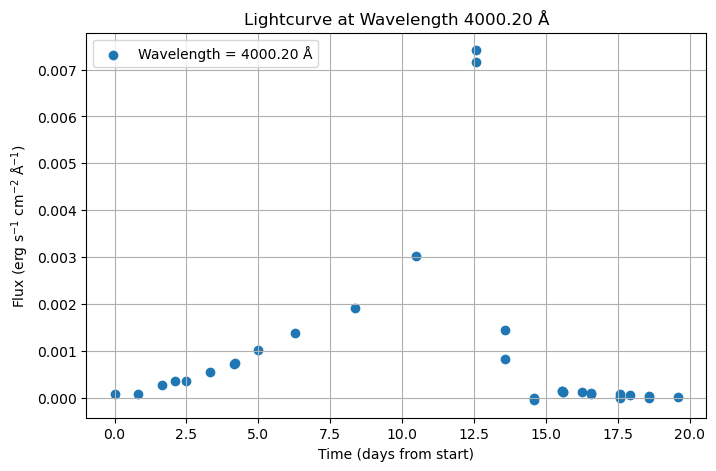

In [18]:
# Plot a light curve at 5000 Å
plot_lightcurve(4000, lookup_table)

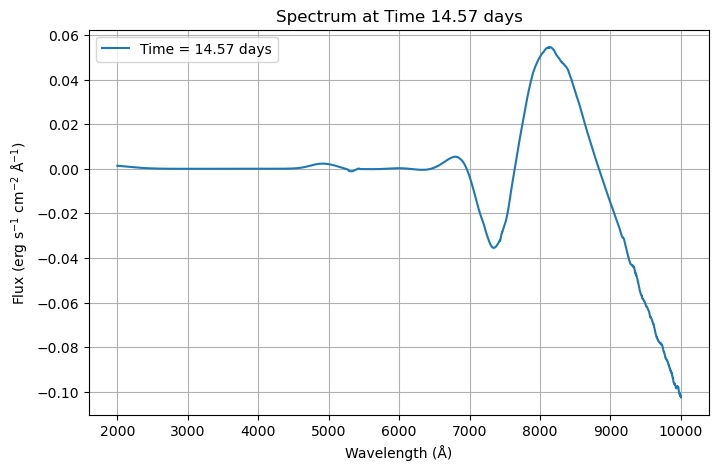

In [25]:
# Plot a spectrum at 20 days from start
plot_spectrum(15, lookup_table, common_wavelengths)

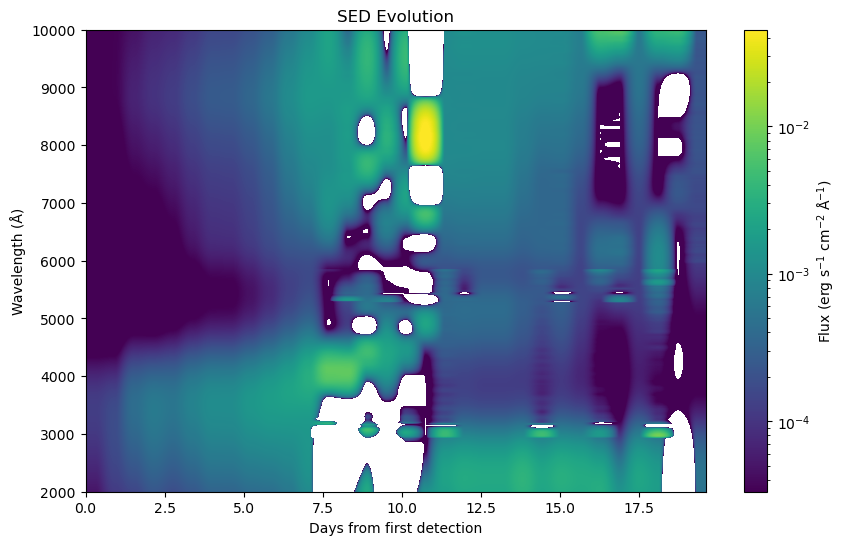

In [20]:

plot_sed_evolution(lookup_table, common_wavelengths, days_from_start)